In [3]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [11]:
# make the model ready
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


model = Sequential([
    base_model,
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')  # binary 0 for brain 1 for no brain
])


base_model.trainable = False
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])

data_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_data = data_gen.flow_from_directory(
    r'D:\data\train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

val_data = data_gen.flow_from_directory(
    r'D:\data\val',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)



history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=5
)



model.save('brain_classifier.h5')


Found 5115 images belonging to 2 classes.
Found 1279 images belonging to 2 classes.
Epoch 1/5
160/160 ━━━━━━━━━━━━━━━━━━━━ 244s 1s/step - accuracy: 0.6741 - loss: 0.9362 - val_accuracy: 0.7303 - val_loss: 0.3142
Epoch 2/5
160/160 ━━━━━━━━━━━━━━━━━━━━ 245s 2s/step - accuracy: 0.9028 - loss: 0.2890 - val_accuracy: 0.9562 - val_loss: 0.2394
Epoch 3/5
160/160 ━━━━━━━━━━━━━━━━━━━━ 242s 2s/step - accuracy: 0.9367 - loss: 0.2478 - val_accuracy: 0.9593 - val_loss: 0.2145
Epoch 4/5
160/160 ━━━━━━━━━━━━━━━━━━━━ 240s 2s/step - accuracy: 0.9557 - loss: 0.2163 - val_accuracy: 0.9593 - val_loss: 0.1928
Epoch 5/5
160/160 ━━━━━━━━━━━━━━━━━━━━ 246s 2s/step - accuracy: 0.9580 - loss: 0.1949 - val_accuracy: 0.9648 - val_loss: 0.1774


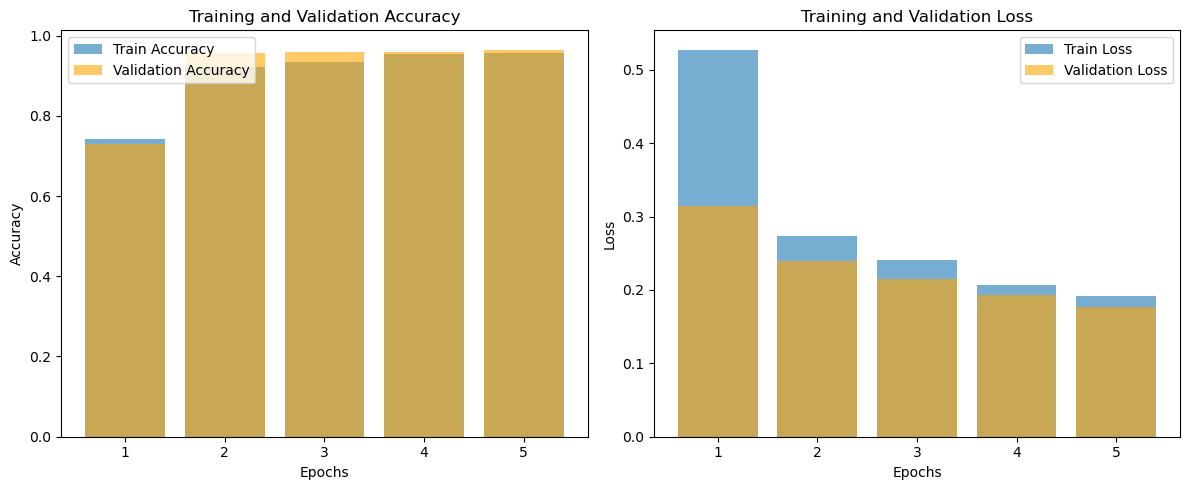

In [13]:
import matplotlib.pyplot as plt

# Extract data from the history object
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_acc) + 1)

# Plot accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.bar(epochs, train_acc, alpha=0.6, label='Train Accuracy')
plt.bar(epochs, val_acc, alpha=0.6, label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.bar(epochs, train_loss, alpha=0.6, label='Train Loss')
plt.bar(epochs, val_loss, alpha=0.6, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
